In [1]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK
from hyperopt import Trials

In [2]:
NUM_FOLDS = 5
NUM_EVALS = 50
SEED = 43
USE_RFE = True

In [3]:
np.set_printoptions(suppress=True)

In [4]:
TRAIN_FILE_DIR = os.path.join('..', 'data', 'training_set.csv')
TEST_FILE_DIR = os.path.join('..', 'data', 'test_set.csv')

In [5]:
df_train = pd.read_csv(TRAIN_FILE_DIR, index_col=0)
df_test = pd.read_csv(TEST_FILE_DIR, index_col=0)

In [6]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X49,X50,X51,X52,X53,X54,X55,X56,X57,Y
0,0.00,0.00,4.34,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,1.342,0.000,0.000,1.200,2,12,0
1,0.00,0.56,0.56,0.00,1.12,0.56,2.25,0.00,0.0,0.56,...,0.0,0.083,0.0,0.503,0.000,0.083,16.304,148,375,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.000,0.000,0.000,1.000,1,5,0
3,0.64,0.00,0.64,0.00,1.93,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.462,0.370,0.000,2.440,22,122,1
4,0.58,0.00,0.00,35.46,0.58,0.00,0.58,0.58,0.0,0.00,...,0.0,0.000,0.0,0.239,0.239,0.000,3.338,123,207,1


In [7]:
df_test.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57
0,0.70,0.0,0.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.000,0.0,0.105,0.000,0.000,2.342,47,89
1,0.00,0.0,0.84,0.0,0.84,0.00,0.84,0.00,0.00,0.00,...,0.0,0.0,0.388,0.0,0.776,0.129,0.000,10.375,168,249
2,0.46,0.3,0.46,0.0,0.05,0.12,0.05,0.28,0.43,0.74,...,0.0,0.0,0.065,0.0,0.325,0.756,0.153,5.891,193,3040
3,0.10,0.2,1.01,0.0,0.80,0.80,0.50,0.00,0.80,0.10,...,0.0,0.0,0.110,0.0,0.490,0.158,0.015,8.550,669,1351
4,0.00,0.0,0.72,0.0,0.72,0.00,0.72,0.00,0.00,0.00,...,0.0,0.0,0.364,0.0,0.729,0.121,0.000,7.781,32,249


In [8]:
COMMON_COLS = [
    col 
    for i,col in enumerate(df_train.columns) 
    if col in df_test.columns
]
print(len(COMMON_COLS))

TARGET_COL = 'Y'

57


In [9]:
print(COMMON_COLS)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57']


### EDA

As we dont know the columns descriptions we will have to assume that all variables are continuous in nature..

In [10]:
df_train[COMMON_COLS].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,3910.0,0.102990,0.296322,0.0,0.00000,0.0000,0.00000,4.340
X2,3910.0,0.206419,1.253828,0.0,0.00000,0.0000,0.00000,14.280
X3,3910.0,0.284419,0.504352,0.0,0.00000,0.0000,0.43000,4.540
X4,3910.0,0.062074,1.369361,0.0,0.00000,0.0000,0.00000,42.810
X5,3910.0,0.311309,0.656195,0.0,0.00000,0.0000,0.38750,9.090
X6,3910.0,0.095974,0.261455,0.0,0.00000,0.0000,0.00000,3.570
X7,3910.0,0.112320,0.389516,0.0,0.00000,0.0000,0.00000,7.270
X8,3910.0,0.106041,0.398694,0.0,0.00000,0.0000,0.00000,11.110
X9,3910.0,0.091146,0.271417,0.0,0.00000,0.0000,0.00000,3.230
X10,3910.0,0.244345,0.667065,0.0,0.00000,0.0000,0.17000,18.180


In [11]:
df_test[COMMON_COLS].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,691.0,0.113401,0.352256,0.0,0.000,0.000,0.0000,4.540
X2,691.0,0.250333,1.481908,0.0,0.000,0.000,0.0000,14.280
X3,691.0,0.259363,0.502791,0.0,0.000,0.000,0.3600,5.100
X4,691.0,0.084385,1.533871,0.0,0.000,0.000,0.0000,35.460
X5,691.0,0.317395,0.758769,0.0,0.000,0.000,0.3750,10.000
X6,691.0,0.095485,0.335553,0.0,0.000,0.000,0.0000,5.880
X7,691.0,0.124891,0.402284,0.0,0.000,0.000,0.0000,5.400
X8,691.0,0.101071,0.414537,0.0,0.000,0.000,0.0000,4.620
X9,691.0,0.083965,0.316430,0.0,0.000,0.000,0.0000,5.260
X10,691.0,0.211505,0.499598,0.0,0.000,0.000,0.1200,4.540


#### Target Distributions

In [12]:
df_train[TARGET_COL].value_counts()

0    2376
1    1534
Name: Y, dtype: int64

In [13]:
df_train[TARGET_COL].value_counts() / df_train.shape[0]

0    0.607673
1    0.392327
Name: Y, dtype: float64

#### Data Drift between training and test set

In [14]:
def feat_imp_to_df(model, features):
    importances = pd.DataFrame(list(zip(features, model.feature_importances_)), columns=['col_nm', 'importance'])
    return importances.sort_values('importance', ascending=False).reset_index(drop=True)

In [15]:
def get_rf_feature_importance(df1, df2):
    df1['dataset'] = 0
    df2['dataset'] = 1
    concat_df = pd.concat([df1[COMMON_COLS + ['dataset']], df2[COMMON_COLS + ['dataset']]])
    print(df1.shape, df2.shape, concat_df.shape)

    FEATURES = [col for col in COMMON_COLS if col != 'dataset']
    RF = RandomForestClassifier(n_estimators=50)
    RF.fit(concat_df[FEATURES], y=concat_df['dataset'])

    print(classification_report(concat_df['dataset'], RF.predict(concat_df[FEATURES])))
    return feat_imp_to_df(RF, FEATURES)

feat_importance = get_rf_feature_importance(df_train, df_test)
feat_importance[:10]

(3910, 59) (691, 58) (4601, 58)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3910
           1       0.98      0.87      0.92       691

    accuracy                           0.98      4601
   macro avg       0.98      0.94      0.96      4601
weighted avg       0.98      0.98      0.98      4601



,col_nm,importance
0,X57,0.077811
1,X55,0.074067
2,X19,0.053293
3,X52,0.051629
4,X50,0.047647
5,X56,0.047267
6,X21,0.035201
7,X12,0.033096
8,X5,0.027455
9,X3,0.027136


Might be best to avoid variables which are highly important in the above model as they are significantly different between training and test datasets

#### Finding multi collinearity

In [16]:
def get_pairwise_correlations(df, columns):
    correlations = df[columns].corr().reset_index(drop=False)
    correlations.columns = ['feature1'] + df[columns].columns.tolist()
    correlations = correlations.melt(id_vars="feature1", var_name="feature2", value_name="corr")
    correlations = correlations.loc[correlations['corr']!=1].copy()
    correlations['col_pair_key'] = correlations.apply(lambda x: '-'.join(sorted([x.feature1, x.feature2])), axis=1)
    correlations = correlations.groupby('col_pair_key', as_index=False)['corr'].max()
    correlations['abs_corr'] = np.abs(correlations['corr'])
    return correlations.sort_values('abs_corr', ascending=False)

get_pairwise_correlations(df_train, COMMON_COLS)

,col_pair_key,corr,abs_corr
1101,X32-X34,0.995241,0.995241
1108,X32-X40,0.831245,0.831245
1167,X34-X40,0.828039,0.828039
1103,X32-X36,0.723539,0.723539
1162,X34-X36,0.720435,0.720435
...,...,...,...
605,X2-X9,0.000199,0.000199
574,X2-X32,0.000161,0.000161
1133,X33-X36,0.000148,0.000148
1342,X4-X9,0.000138,0.000138


#### Sparcity

In [17]:
train_zero_counts = ((df_train[COMMON_COLS] == 0).sum() / df_train.shape[0]).reset_index(drop=False, name='zero_count')
print((df_train[COMMON_COLS] == 0).sum().sum() / (df_train.shape[0] * df_train.shape[1]))
train_zero_counts.sort_values("zero_count", ascending=False)[:15]

0.747214877107807


,index,zero_count
3,X4,0.990026
46,X47,0.985678
37,X38,0.981074
21,X22,0.977238
40,X41,0.967775
47,X48,0.956010
31,X32,0.954987
33,X34,0.952941
30,X31,0.936317
14,X15,0.927877


In [18]:
test_zero_counts = ((df_test[COMMON_COLS] == 0).sum() / df_test.shape[0]).reset_index(drop=False, name='zero_count')
print((df_test[COMMON_COLS] == 0).sum().sum() / (df_test.shape[0] * df_test.shape[1]))
test_zero_counts.sort_values("zero_count", ascending=False)[:15]

0.7647836718399121


,index,zero_count
46,X47,0.989870
3,X4,0.988423
37,X38,0.986975
40,X41,0.968162
21,X22,0.959479
31,X32,0.958032
33,X34,0.955137
47,X48,0.955137
43,X44,0.937771
30,X31,0.936324


#### Missing info

In [19]:
print(df_train.isna().sum().to_dict())

{'X1': 0, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0, 'X6': 0, 'X7': 0, 'X8': 0, 'X9': 0, 'X10': 0, 'X11': 0, 'X12': 0, 'X13': 0, 'X14': 0, 'X15': 0, 'X16': 0, 'X17': 0, 'X18': 0, 'X19': 0, 'X20': 0, 'X21': 0, 'X22': 0, 'X23': 0, 'X24': 0, 'X25': 0, 'X26': 0, 'X27': 0, 'X28': 0, 'X29': 0, 'X30': 0, 'X31': 0, 'X32': 0, 'X33': 0, 'X34': 0, 'X35': 0, 'X36': 0, 'X37': 0, 'X38': 0, 'X39': 0, 'X40': 0, 'X41': 0, 'X42': 0, 'X43': 0, 'X44': 0, 'X45': 0, 'X46': 0, 'X47': 0, 'X48': 0, 'X49': 0, 'X50': 0, 'X51': 0, 'X52': 0, 'X53': 0, 'X54': 0, 'X55': 0, 'X56': 0, 'X57': 0, 'Y': 0, 'dataset': 0}


In [20]:
print(df_test.isna().sum().to_dict())

{'X1': 0, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0, 'X6': 0, 'X7': 0, 'X8': 0, 'X9': 0, 'X10': 0, 'X11': 0, 'X12': 0, 'X13': 0, 'X14': 0, 'X15': 0, 'X16': 0, 'X17': 0, 'X18': 0, 'X19': 0, 'X20': 0, 'X21': 0, 'X22': 0, 'X23': 0, 'X24': 0, 'X25': 0, 'X26': 0, 'X27': 0, 'X28': 0, 'X29': 0, 'X30': 0, 'X31': 0, 'X32': 0, 'X33': 0, 'X34': 0, 'X35': 0, 'X36': 0, 'X37': 0, 'X38': 0, 'X39': 0, 'X40': 0, 'X41': 0, 'X42': 0, 'X43': 0, 'X44': 0, 'X45': 0, 'X46': 0, 'X47': 0, 'X48': 0, 'X49': 0, 'X50': 0, 'X51': 0, 'X52': 0, 'X53': 0, 'X54': 0, 'X55': 0, 'X56': 0, 'X57': 0, 'dataset': 0}


#### Model Training & Cross Validation

In [21]:
bayes_trials = Trials()

space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_samples_split' : hp.quniform('min_samples_split', 2, 50, 1),
    'n_estimators': hp.quniform('n_estimators', 20, 50, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_samples' : hp.uniform('max_samples', 0.5, 1),
    'min_samples_leaf' : hp.randint('min_samples_leaf', 2, 9)
}

KF = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED) # this will split the data in the ratio 4:1

In [22]:
indices = list(range(df_train.shape[0]))
train_indices, valid_indices = train_test_split(indices, train_size=0.8, random_state=SEED)
print(df_train.shape[0], len(train_indices), len(valid_indices))

df_valid = df_train.iloc[valid_indices].copy().reset_index(drop=True)
df_train = df_train.iloc[train_indices].copy().reset_index(drop=True)
print(df_train.shape, df_valid.shape)

3910 3128 782
(3128, 59) (782, 59)


In [23]:
def objective(params, verbose=True):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split' : int(params['min_samples_split']),
        'n_estimators' : int(params['n_estimators']),
        'criterion' : params['criterion'],
        'max_samples' : float(params['max_samples']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }

    clf = RandomForestClassifier(oob_score=True,
                                 n_jobs=-1,
                                 random_state=SEED,
                                 verbose=0,
                                 **params)

    score = cross_val_score(estimator=clf,
                            X=df_train[COMMON_COLS].values,
                            y=df_train[TARGET_COL].values,
                            verbose=0,
                            scoring='accuracy',
                            cv=KF).mean()
    
    if verbose: print("Accuracy Score {:.3f} params {}".format(score, params))
    return {"loss": -1.0 * score, "params": params, "status": STATUS_OK}

In [24]:
hpt_experiments = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=NUM_EVALS, trials=bayes_trials)

Accuracy Score 0.922 params {'max_depth': 5, 'min_samples_split': 42, 'n_estimators': 32, 'criterion': 'entropy', 'max_samples': 0.8140271176197449, 'min_samples_leaf': 6}
Accuracy Score 0.923 params {'max_depth': 6, 'min_samples_split': 28, 'n_estimators': 23, 'criterion': 'entropy', 'max_samples': 0.7301141615383153, 'min_samples_leaf': 8}
Accuracy Score 0.927 params {'max_depth': 6, 'min_samples_split': 46, 'n_estimators': 39, 'criterion': 'entropy', 'max_samples': 0.9204581927959763, 'min_samples_leaf': 2}
Accuracy Score 0.917 params {'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 22, 'criterion': 'gini', 'max_samples': 0.7092942933117026, 'min_samples_leaf': 8}
Accuracy Score 0.927 params {'max_depth': 6, 'min_samples_split': 23, 'n_estimators': 30, 'criterion': 'gini', 'max_samples': 0.9090059006473026, 'min_samples_leaf': 8}
Accuracy Score 0.933 params {'max_depth': 8, 'min_samples_split': 35, 'n_estimators': 26, 'criterion': 'entropy', 'max_samples': 0.927750004777673

In [25]:
optimal_params = {
    'max_depth': int(hpt_experiments['max_depth']),
    'min_samples_split': int(hpt_experiments['min_samples_split']),
    'n_estimators': int(hpt_experiments['n_estimators']),
    'criterion': ['gini', 'entropy'][hpt_experiments['criterion']],
    'max_samples' : float(hpt_experiments['max_samples']),
    'min_samples_leaf': int(hpt_experiments['min_samples_leaf'])
}

best_loss = np.round(bayes_trials.best_trial['result']['loss'], 4)
print(f"Best loss of {best_loss} corresponds to the following configuration:")
print(optimal_params)

Best loss of -0.9386 corresponds to the following configuration:
{'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 29, 'criterion': 'gini', 'max_samples': 0.9996310028997908, 'min_samples_leaf': 2}


#### Feature Selection using RFE
Given the best params (cross validated) we have for the data, we can now quickly reduce the number of features by removing unimportant features through Recursive Feature Elimination

In [26]:
classifier_model = RandomForestClassifier(**{
    "oob_score":True,
    "n_jobs":-1,
    "random_state":SEED,
    "verbose":1,
    "class_weight":"balanced",
    **optimal_params
})

rec_feat_sel = RFE(estimator=classifier_model, n_features_to_select=15, step=2, verbose=0)
rec_feat_sel.fit(X=df_train[COMMON_COLS], y=df_train[TARGET_COL])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight='balanced', criterion='gini',
                                     max_depth=9, max_features='auto',
                                     max_leaf_nodes=None,
                                     max_samples=0.9996310028997908,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=2, min_samples_split=11,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=29, n_jobs=-1, oob_score=True,
                                     random_state=43, verbose=1,
                                     warm_start=False),
    n_features_to_select=15, step=2, verbose=0)

In [27]:
RFE_FEATURES = np.array(COMMON_COLS)[rec_feat_sel.get_support()].tolist()

#### Final fit

In [28]:
tuned_rf = RandomForestClassifier(**{
    "oob_score":True,
    "n_jobs":-1,
    "random_state":SEED,
    "verbose":1,
    "class_weight":"balanced",
    **optimal_params
})

FEATURES = RFE_FEATURES if USE_RFE else COMMON_COLS

tuned_rf.fit(X=df_train[FEATURES], y=df_train[TARGET_COL])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.9996310028997908,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=-1,
                       oob_score=True, random_state=43, verbose=1,
                       warm_start=False)

#### Model Evaluation

In [29]:
preds_train = tuned_rf.predict(df_train[FEATURES])
preds_valid = tuned_rf.predict(df_valid[FEATURES])
preds_test = tuned_rf.predict(df_test[FEATURES])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


In [30]:
print(classification_report(df_train[TARGET_COL], preds_train))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1911
           1       0.96      0.93      0.94      1217

    accuracy                           0.96      3128
   macro avg       0.96      0.95      0.95      3128
weighted avg       0.96      0.96      0.96      3128



In [31]:
print(classification_report(df_valid[TARGET_COL], preds_valid))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       465
           1       0.93      0.90      0.91       317

    accuracy                           0.93       782
   macro avg       0.93      0.93      0.93       782
weighted avg       0.93      0.93      0.93       782



0.9499416731486224


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


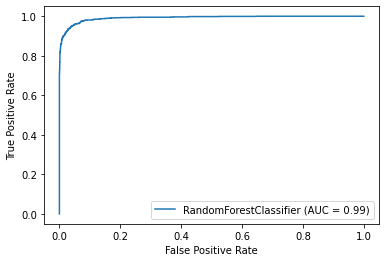

In [32]:
print(roc_auc_score(df_train[TARGET_COL], preds_train))
plot_roc_curve(tuned_rf, df_train[FEATURES], df_train[TARGET_COL])

0.9253688816525898


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


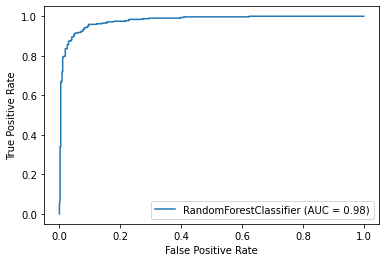

In [33]:
print(roc_auc_score(df_valid[TARGET_COL], preds_valid))
plot_roc_curve(tuned_rf, df_valid[FEATURES], df_valid[TARGET_COL])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


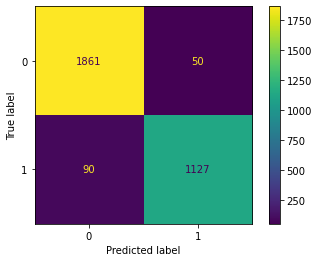

In [41]:
plot_confusion_matrix(tuned_rf, df_train[FEATURES], df_train[TARGET_COL], values_format='')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


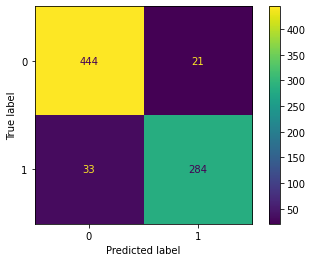

In [34]:
plot_confusion_matrix(tuned_rf, df_valid[FEATURES], df_valid[TARGET_COL], values_format='')

In [35]:
if USE_RFE:
    print(feat_imp_to_df(tuned_rf, FEATURES))
else:
    print(feat_imp_to_df(tuned_rf, FEATURES)[:10])

   col_nm  importance
0     X52    0.201811
1      X7    0.122683
2     X53    0.111047
3     X56    0.094752
4     X25    0.089620
5     X21    0.084423
6     X16    0.068855
7     X55    0.058680
8     X57    0.036003
9      X5    0.027116
10    X27    0.027044
11    X19    0.022415
12    X26    0.021299
13    X46    0.019927
14    X24    0.014324


#### Test Outputs

In [36]:
# Save the model to results folder
joblib.dump(tuned_rf, os.path.join('..', 'results', 'model.pkl'))

['..\\results\\model.pkl']

In [37]:
df_test['predictions'] = tuned_rf.predict(df_test[FEATURES])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 out of  29 | elapsed:    0.0s finished


In [38]:
df_test['predictions'].value_counts() / df_test.shape[0]

0    0.616498
1    0.383502
Name: predictions, dtype: float64

In [39]:
df_test[['predictions']].to_csv(os.path.join('..', 'results', 'test_predictions.csv'), index=True)